Baseline Clustering

In [15]:
import sys
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import psycopg2.extras

root_path = Path().resolve().parent.parent.parent
sys.path.append(str(root_path))

from src.dataset.connection import connect_to_spotify_dataset
from src.dataset.connection import select

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score

import torch
import torch.nn.functional as F


import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
connection = connect_to_spotify_dataset() # Add db Password
if not connection:
    print("Connection Error")
tds = select(connection, "SELECT * FROM track_data") 

Connection successful
Connection closed.


In [3]:
columns = [
    "id", "name", "popularity", "duration_ms", "explicit", "artists", "id_artists", "release_date",
    "danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", 
    "instrumentalness", "liveness", "valence", "tempo", "time_signature","decade", "mood_index", "emotion_index", "party_index", "chill_index"
]
# Create the DataFrame
df = pd.DataFrame(tds, columns=columns)
#df = df.iloc[:10000]
print(df.dtypes)
df.head()

id                   object
name                 object
popularity            int64
duration_ms           int64
explicit               bool
artists              object
id_artists           object
release_date         object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                   bool
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
decade                int64
mood_index          float64
emotion_index       float64
party_index         float64
chill_index         float64
dtype: object


,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,instrumentalness,liveness,valence,tempo,time_signature,decade,mood_index,emotion_index,party_index,chill_index
0,73gfHKufFmtlEBfPhfXrca,Soy Esclavo de Tu Cuerpo,44,195571,False,"[Yampi, Anuel AA]","[3Ia6QnB1tPR9bcgnmbL5FO, 2R21vXR83lH98kGeO99Y66]",2014-02-28,0.705,0.660,...,0.020200,0.0885,0.484,89.980,4,2010,0.5855,1.6198,0.6825,0.40360
1,4DN86kfq76ltzhRt0Zbfh7,Despídete con Un Beso,40,249289,False,[Buddy Richard],[6qSkZrS7Xdje9DVRXlNmpE],2014-01-01,0.520,0.577,...,0.000123,0.1500,0.866,121.070,4,2010,0.7044,3.1847,0.5485,0.36000
2,6Ubz6F0BwkiSk0b1qfXUjl,Creo en Ti,42,240568,False,"[Ana Tijoux, Juanito Ayala]","[40JMTpVRUw90SrN4pFA6Mz, 4Wy8CFlIS11ODC9wVKBSz4]",2014-04-15,0.746,0.578,...,0.000017,0.1450,0.674,91.984,4,2010,0.6764,2.6396,0.6620,0.20474
3,0HqtzBaZpjoEZ84WbbEcoe,Fumo Marihuana,47,213861,True,"[Morodo, Heavy Roots]","[2OnH4HpywAxWkSOEsyjdjn, 4fEogLHgLSsp5ETlJCci09]",2014-10-06,0.797,0.780,...,0.000000,0.2860,0.890,127.946,4,2010,0.8401,1.7414,0.7885,0.37000
4,35TRct8Yqqmy0XUPg8UFbn,Nabundearé,39,175413,False,[Nicole Bunout],[5jyOjqLd2YRArrVlguvv4F],2014,0.433,0.387,...,0.000010,0.1200,0.229,102.648,4,2010,0.3218,3.2686,0.4100,0.65560


In [4]:
df_baseline = df[['duration_ms', 'tempo', 'decade', 'popularity', 'key', 'emotion_index', 'mode', 'chill_index']]
df_baseline.head()

,duration_ms,tempo,decade,popularity,key,emotion_index,mode,chill_index
0,195571,89.980,2010,44,10,1.6198,False,0.40360
1,249289,121.070,2010,40,1,3.1847,True,0.36000
2,240568,91.984,2010,42,4,2.6396,False,0.20474
3,213861,127.946,2010,47,1,1.7414,True,0.37000
4,175413,102.648,2010,39,11,3.2686,False,0.65560


In [5]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_baseline)

In [6]:
df_scaled.size

4204696

In [7]:
from src.utils import distributed_silhouette
distributed_silhouette = distributed_silhouette.DistributedSilhouette()



In [11]:
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score

X= df_scaled
# Assume X is your dataset
n_clusters = 8  # or any number of clusters you're using for KMeans
random_labels = np.random.randint(0, n_clusters, size=len(X))

# Evaluate random clustering
partitions, label_partitions = distributed_silhouette.split_data(df_scaled, random_labels)

silhouette_random = distributed_silhouette.compute_fast_silhouette(partitions, label_partitions)

dbi_random = davies_bouldin_score(X, random_labels)

print(f"Random Clustering - \nSilhouette Score: {silhouette_random}, \nDavies-Bouldin Index: {dbi_random}")


Setting up the droplet clones...
We are ready to compute the score in parallel!
Calculating...
Done! Cleaning up droplets...
Destroyed droplet: silhouette-clone-0
Destroyed droplet: silhouette-clone-1
Destroyed droplet: silhouette-clone-2
Destroyed droplet: silhouette-clone-3
Destroyed droplet: silhouette-clone-4
Destroyed droplet: silhouette-clone-5
Destroyed droplet: silhouette-clone-6
Destroyed droplet: silhouette-clone-7
Destroyed droplet: silhouette-clone-8
Destroyed droplet: silhouette-clone-9
Droplets destroyed, you are safe to terminate your code!
Random Clustering - 
Silhouette Score: -0.004596375818168725, 
Davies-Bouldin Index: 642.5585764602409


In [13]:
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans

# Compute centroids for random clusters
def compute_centroids(X, labels, n_clusters):
    centroids = np.zeros((n_clusters, X.shape[1]))
    for i in range(n_clusters):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            centroids[i] = np.mean(cluster_points, axis=0)
    return centroids

# Compute inertia
def compute_inertia(X, labels, centroids):
    inertia = 0
    for i in range(len(X)):
        cluster = labels[i]
        inertia += np.sum((X[i] - centroids[cluster]) ** 2)
    return inertia

# Convert DataFrame to NumPy array
X_array = X

# Compute centroids for the randomly assigned clusters
centroids = compute_centroids(X_array, random_labels, n_clusters)

# Compute inertia
inertia_random = compute_inertia(X_array, random_labels, centroids)

print(f"Random Clustering - \nInertia: {inertia_random}")


Random Clustering - 
Inertia: 4204657.864570173


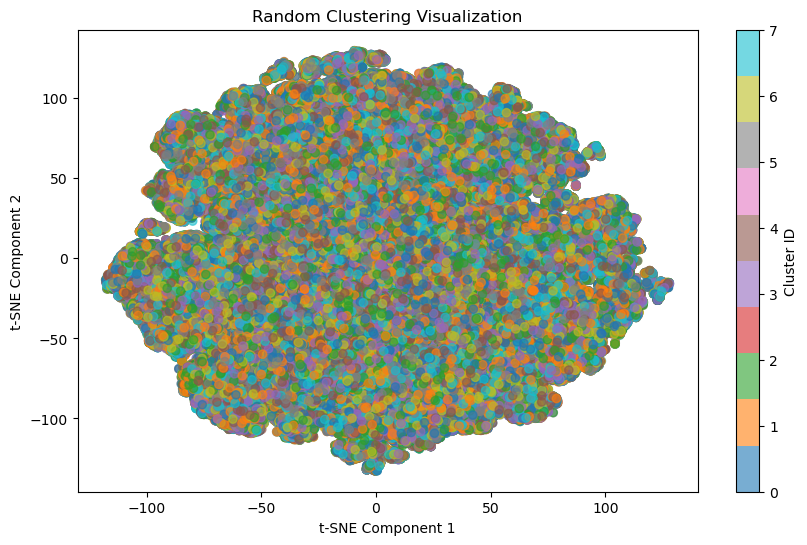

In [16]:
#TSNE for Random CLustering
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d = tsne.fit_transform(X)

# Plot the random clustering
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=random_labels, cmap="tab10", alpha=0.6)
plt.colorbar(scatter, label="Cluster ID")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Random Clustering Visualization")
plt.show()

Random Clustering - 

Inertia: 4204645.621554496
Silhouette Score: -0.004608494131524032

Davies-Bouldin Index: 491.22270561847176

GMM - Gaussian Mixture Model

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=8, random_state=42)
labels_gmm = gmm.fit_predict(X)

partitions, label_partitions = distributed_silhouette.split_data(X, labels_gmm)
silhouette_gmm = distributed_silhouette.compute_fast_silhouette(partitions, label_partitions)
dbi_gmm = davies_bouldin_score(X, labels_gmm)
print(f"Random Clustering - \nSilhouette Score: {silhouette_gmm}, \nDavies-Bouldin Index: {dbi_gmm}")



Setting up the droplet clones...
We are ready to compute the score in parallel!
Calculating...
Done! Cleaning up droplets...
Destroyed droplet: silhouette-clone-0
Destroyed droplet: silhouette-clone-1
Destroyed droplet: silhouette-clone-2
Destroyed droplet: silhouette-clone-3
Destroyed droplet: silhouette-clone-4
Destroyed droplet: silhouette-clone-5
Destroyed droplet: silhouette-clone-6
Destroyed droplet: silhouette-clone-7
Destroyed droplet: silhouette-clone-8
Destroyed droplet: silhouette-clone-9
Droplets destroyed, you are safe to terminate your code!
Random Clustering - 
Silhouette Score: 0.08833424194399461, 
Davies-Bouldin Index: 491.22270561847176


In [ ]:
means_gmm = gmm.means_  # Get Gaussian component means (cluster centers)

# Compute Inertia-like measure (sum of squared distances to assigned Gaussian component mean)
def compute_gmm_inertia(X, labels, means):
    inertia = 0
    for i in range(len(X)):
        cluster = labels[i]
        inertia += np.sum((X[i] - means[cluster]) ** 2)
    return inertia

# Convert DataFrame to NumPy array
X_array = X

# Compute GMM Inertia
inertia_gmm = compute_gmm_inertia(X_array, labels_gmm, means_gmm)

print(f"GMM Clustering - \nInertia (Sum of Squared Distances): {inertia_gmm}")
'''
Since GMM does soft clustering, inertia isn't as well-defined as in KMeans, 
but the sum of squared distances to the assigned Gaussian mean provides 
a comparable measure.'''

GMM Clustering - 
Inertia (Sum of Squared Distances): 2504443.5983214374


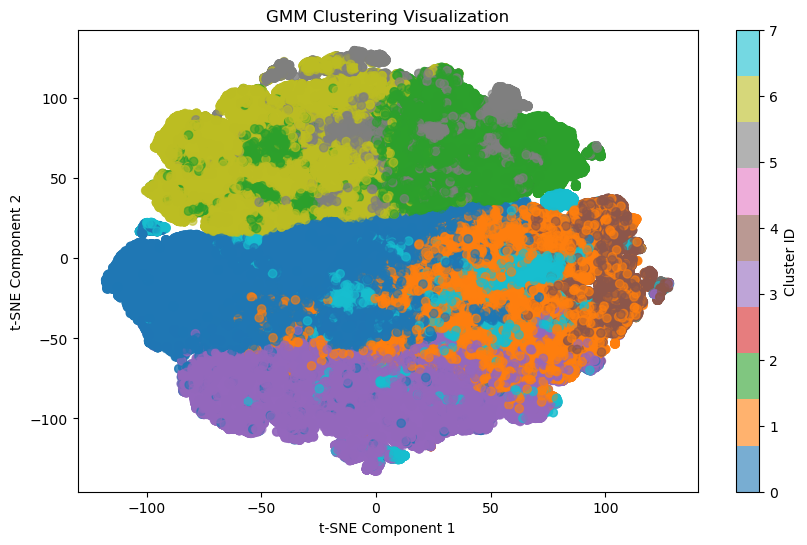

In [18]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_gmm, cmap="tab10", alpha=0.6)
plt.colorbar(scatter, label="Cluster ID")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("GMM Clustering Visualization")
plt.show()

Gaussian Mixture Model - 

Inertia (Sum of Squared Distances): 2504443.5983214374

Silhouette Score: 0.08833424194399461


Davies-Bouldin Index: 2.0470611600249145

Null Model (Permutation Test)
The null hypothesis assumes that there is no true cluster structure in the data.
Randomly permute the data points (feature values) and running the clustering algorithm again to compare performance

In [ ]:
X_permuted = np.random.permutation(X)
kmeans_perm = KMeans(n_clusters=8, random_state=42)
labels_perm = kmeans_perm.fit_predict(X_permuted)

partitions, label_partitions = distributed_silhouette.split_data(X, labels_perm)
silhouette_perm = distributed_silhouette.compute_fast_silhouette(partitions, label_partitions)
dbi_perm = davies_bouldin_score(X, labels_perm)
print(f"Random Clustering - \nSilhouette Score: {silhouette_perm}, \nDavies-Bouldin Index: {dbi_perm}")


Setting up the droplet clones...
We are ready to compute the score in parallel!
Calculating...
Done! Cleaning up droplets...
Destroyed droplet: silhouette-clone-0
Destroyed droplet: silhouette-clone-1
Destroyed droplet: silhouette-clone-2
Destroyed droplet: silhouette-clone-3
Destroyed droplet: silhouette-clone-4
Destroyed droplet: silhouette-clone-5
Destroyed droplet: silhouette-clone-6
Destroyed droplet: silhouette-clone-7
Destroyed droplet: silhouette-clone-8
Destroyed droplet: silhouette-clone-9
Droplets destroyed, you are safe to terminate your code!
Random Clustering - 
Silhouette Score: -0.005457596000588488, 
Davies-Bouldin Index: 491.22270561847176


In [23]:
inertia_perm = kmeans_perm.inertia_
print(f"KMeans on Permuted Data - \nInertia: {inertia_perm}")

KMeans on Permuted Data - 
Inertia: 2213409.740902376


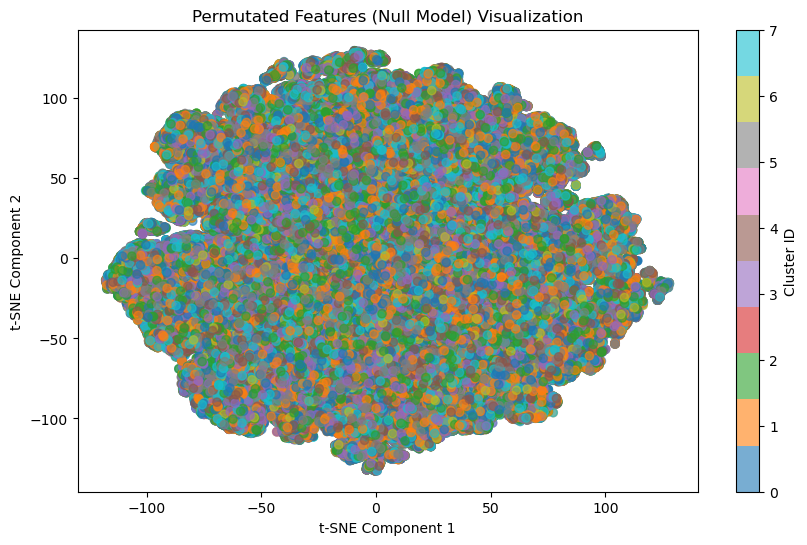

In [20]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_perm, cmap="tab10", alpha=0.6)
plt.colorbar(scatter, label="Cluster ID")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Permutated Features (Null Model) Visualization")
plt.show()

Null Model - 

Inertia: 2213409.740902376

Silhouette Score: -0.005457596000588488, 

Davies-Bouldin Index: 587.1649645919061